# MINIPROJECT 1

## Classification, weight sharing, auxiliary losses


The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective.

### 0. Import libraries

In [2]:
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.init import xavier_uniform_, xavier_normal_

import time
import random
import matplotlib.pyplot as plt

from dlc_practical_prologue import generate_pair_sets

### 1. Generate data

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(1000)

def normalize_data(train_input, test_input):
    mu, std = train_input.mean(), train_input.std()
    train_input.sub_(mu).div_(std)
    test_input.sub_(mu).div_(std)
    
def to_one_hot(tensor):
    
    one_hot = torch.zeros((tensor.size(0), 10)).type(torch.FloatTensor)
    one_hot[list(range(0,tensor.size(0))), tensor[:,0]] = 1
    return one_hot

def shuffle(t_input, classes, target):
    idx = [i for i in range(t_input.size(0))]
    random.shuffle(idx)
    return t_input[idx,:,:,:], classes[idx, :], target[idx,:]

def binarize(target):
    target_bin = torch.zeros((target.size(0), 2))
    target_bin[list(range(target.size(0))), target[:]] = 1
    return target_bin

# convert to binary target
train_target_bin, test_target_bin = binarize(train_target), binarize(test_target)

# shuffle train set
train_input, train_classes, train_target_bin = shuffle(train_input, train_classes, train_target_bin)

# reshape 
train_input = train_input.reshape((train_input.size(0)*2, 1, train_input.size(2), train_input.size(3)))
test_input = test_input.reshape((test_input.size(0)*2, 1, test_input.size(2), test_input.size(3)))

# normalize
normalize_data(train_input, test_input)

# convert to one hot encoding
train_classes_one_hot = to_one_hot(train_classes.view(train_classes.size(0)*2, -1))
test_classes_one_hot  = to_one_hot(test_classes.view(test_classes.size(0)*2, -1))

In [4]:
print('Number of train samples of type 0:\t {}. \t Number of train samples of type 1: \t {}'.format(1000 - sum(train_target), sum(train_target)))
print('Number of test samples of type 0:\t {}.  \t Number of test samples of type 1: \t {}'.format(1000 - sum(test_target), sum(test_target)))

Number of train samples of type 0:	 449. 	 Number of train samples of type 1: 	 551
Number of test samples of type 0:	 474.  	 Number of test samples of type 1: 	 526


In [9]:
print(train_input.shape, train_classes_one_hot.shape, train_target_bin.shape, train_classes.shape)

torch.Size([2000, 1, 14, 14]) torch.Size([2000, 10]) torch.Size([1000, 2]) torch.Size([1000, 2])


In [10]:
print(train_classes[0:10])

tensor([[9, 4],
        [3, 9],
        [0, 3],
        [7, 0],
        [3, 9],
        [4, 5],
        [1, 0],
        [5, 0],
        [3, 9],
        [8, 3]])


### 2. Define train function and other auxiliary functions that can be necessary


In [6]:
# Define training function for two-stage model

def train_model(model, train_input, train_target, epochs=25, \
                mini_batch_size=100, lr=1e-3, criterion=None, optimizer=None, verbose=2):
    # use MSE loss by default
    if not criterion:
        criterion = nn.MSELoss()
        
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)
    loss_store = []
    
    for e in range(epochs):
        sum_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            sum_loss = sum_loss + loss.item()
            optimizer.step()
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        loss_store.append(sum_loss)
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
        
    return loss_store    

            
# Define training function for complete model          
def train_model_all(model, train_input, train_classes, train_target, epochs=25, \
                mini_batch_size=100, lr=1e-3, w1=1, w2=1, criterion1=None, criterion2=None, optimizer=None, verbose=2):
    
    print('Training Composed model')
    
    # use MSE loss by default
    if not criterion1:
        criterion1 = nn.MSELoss()
    if not criterion2:
        criterion2 = nn.MSELoss()
        
    # use SGD by default
    if not optimizer:
        optimizer = optim.SGD(model.parameters(), lr = lr)

    loss_store = []
    for e in range(epochs):
        sum_loss = 0
        
        for b in range(0, train_target.size(0), mini_batch_size):
            output_classes, output_final = model(train_input.narrow(0, b*2, mini_batch_size*2))
            loss1 = criterion1(output_classes, train_classes.narrow(0, b*2, mini_batch_size*2))
            loss2 = criterion2(output_final, train_target.narrow(0, b, mini_batch_size))
            loss = w1*loss1 + w2*loss2
            model.zero_grad()
            loss.backward(retain_graph=True)
            sum_loss = sum_loss + loss.item()
            optimizer.step()
            #for p in model.parameters():
            #    p.data.sub_(lr * p.grad.data)
        loss_store.append(sum_loss)
        
        if verbose == 0: print('Epoch: {}, loss: {:0.2f}'.format(e, sum_loss))
        elif verbose == 1 and e%5 == 0: print(e, sum_loss)
        
    return loss_store
            


def compute_nb_errors(model, input, target, mini_batch_size=100):
    errors = 0

    for b in range(0, input.size(0), mini_batch_size):
        output = model(input.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        for k in range(mini_batch_size):
            if target.data[b + k, predicted_classes[k]] <= 0:
                errors = errors + 1
    return errors


    


In [7]:

class Net_Conv(nn.Module):
    def __init__(self, nb_hidden):
        super(Net_Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x    
    

class Net_Full(nn.Module):
    def __init__(self):
        super(Net_Full, self).__init__()
        self.fc1 = nn.Linear(20, 50)
        self.fc2 = nn.Linear(50,100)
        self.fc3 = nn.Linear(100, 2)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Net_All(nn.Module):
    def __init__(self, nb_h1, nb_h2, nb_h4, nb_h5):
        super(Net_All, self).__init__()
        self.conv1 = nn.Conv2d(1,nb_h1, kernel_size=5)
        self.conv2 = nn.Conv2d(nb_h1, nb_h2, kernel_size=3)
        self.conv3 = nn.Conv2d(nb_h2, 32, kernel_size=1)
        self.fc1 = nn.Linear(32*6*6, nb_h4)
        self.fc2 = nn.Linear(nb_h4, 10)
        self.fc3 = nn.Linear(20, nb_h5)
        self.fc4 = nn.Linear(nb_h5,2)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=1))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(-1, (32*6*6))))
        x_classes = F.relu(self.fc2(x))
        x_out = F.relu(self.fc3(x_classes.view(-1, 20)))
        x_out = self.fc4(x_out)
        return x_classes, x_out
    
    
class Net_small_all(nn.Module):
    def __init__(self, nb_h1, nb_h2, nb_h3):
        super(Net_small_all, self).__init__()
        self.size_h2 = nb_h2
        self.conv1 = nn.Conv2d(1,nb_h1, kernel_size=5)
        self.conv2 = nn.Conv2d(nb_h1, nb_h2, kernel_size=3)
        self.fc1 = nn.Linear(nb_h2*7*7, 10)
        self.fc2 = nn.Linear(20, nb_h3)
        self.fc3 = nn.Linear(nb_h3,2)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=1))
        x = F.relu(self.conv2(x))
        x_classes = F.relu(self.fc1(x.view(-1, (self.size_h2*7*7))))
        x_out = F.relu(self.fc2(x_classes.view(-1, 20)))
        x_out = self.fc3(x_out)
        return x_classes, x_out

In [27]:
model = Net_small_all(2**4, 2**7, 2**5)
p = sum([params.numel() for params in model.parameters()])
print(p)

82444


### 3. Generate Conv + loss 1 + MLP + loss 2 feed with original classes 


In [14]:
train_input, train_target_bin, train_classes_one_hot, train_classes = Variable(train_input), Variable(train_target_bin), Variable(train_classes_one_hot), Variable(train_classes)
test_input, test_target_bin, test_classes_one_hot, test_classes = Variable(test_input), Variable(test_target_bin), Variable(test_classes_one_hot), Variable(test_classes)
print(train_input.shape, train_target_bin.shape, train_classes_one_hot.shape, train_classes.shape)
print(test_input.shape, test_target_bin.shape, test_classes_one_hot.shape, test_classes.shape)

torch.Size([2000, 1, 14, 14]) torch.Size([1000, 2]) torch.Size([2000, 10]) torch.Size([1000, 2])
torch.Size([2000, 1, 14, 14]) torch.Size([1000, 2]) torch.Size([2000, 10]) torch.Size([1000, 2])


In [21]:
def test_model_separate(nb_h, train_i_org, train_c_org, train_t_org, test_i_org=None, test_c_org=None, test_t_org=None, runs=10, epochs=25):
    
    # shuffle train
    train_i_org, train_c_org, train_t_org = shuffle(train_i_org.view(train_i_org.size(0)//2, 2, train_i_org.size(2), -1), train_c_org.view(train_c_org.size(0)//2, -1), train_t_org)
    idx = list(range(train_i_org.size(0)))
    max_l = train_i_org.size(0)
    
    nb_error_test = []
    loss_store = []
    
    for k in range(runs):
        model1 = Net_Conv(nb_h)
        model2 = Net_Full()

        
        # if validation mode for hyperparameter tunning
        if test_i_org is None:
            test_idx = idx[max_l//10*k: max_l//10*(k+1)]
            train_idx =  [i for i in idx if i not in set(test_idx)]
            train_i, test_i = train_i_org[train_idx, :, :, :], train_i_org[test_idx, :, :, :]
            train_c, test_x = train_c_org[train_idx, :], train_c_org[test_idx, :]
            train_t, test_t = train_t_org[train_idx, :], train_t_org[test_idx, :]
        else:
            test_i, train_i = test_i_org, train_i_org
            test_c, train_c = test_c_org, train_c_org
            test_t, train_t = test_t_org, train_t_org
    
        #print('Training convolutional model')
        train_model(model1, train_i.view(-1, 1, train_i.size(2), train_i.size(3)), train_c.view(-1, 10), lr=1, verbose=2, epochs=epochs)
        #print('Training fully connected model')
        loss_store.append(train_model(model2, train_c.view(-1,20), train_t, lr=5e-1, verbose=2)) 

        _, out1 = model1(test_i.view(-1,1,test_i.size(2), test_i.size(3))).max(1)
        out = model2(to_one_hot(out1.view(-1,1)).view(-1,20))
        _, argm = out.max(1)
        _, argm_t = test_t.max(1)
        nb_test_errors = test_t.size(0) - ((argm == argm_t).sum(0))
        nb_error_test.append(100.0*nb_test_errors/test_t.size(0))
        print('test error {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / test_t.size(0),
                                                          nb_test_errors, test_t.size(0)))
    p1 = sum([params.numel() for params in model1.parameters()])
    p2 = sum([params.numel() for params in model2.parameters()])
    print('Model with {} parameters \t'.format(p1+p2))
    errors = torch.tensor(nb_error_test).type(torch.FloatTensor)
    print('Mean error: {:0.2f} Std deviation in error: {:0.2f}'.format(errors.mean(), errors.std()))
    return nb_error_test, loss_store

In [22]:
_, loss = test_model_separate(200, train_input, train_classes_one_hot, train_target_bin)

test error 2.00% 2/100
test error 1.00% 1/100
test error 4.00% 4/100
test error 6.00% 6/100
test error 2.00% 2/100
test error 2.00% 2/100
test error 5.00% 5/100
test error 5.00% 5/100
test error 2.00% 2/100
test error 1.00% 1/100
Model with 85842 parameters 	
Mean error: 3.00 Std deviation in error: 1.83


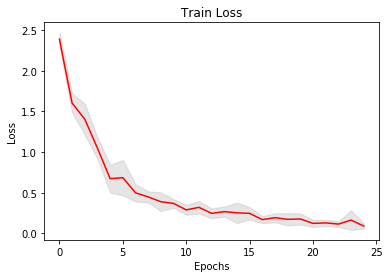

In [12]:
l = torch.tensor(loss)
loss_m = l.mean(0)
loss_std = l.std(0)
xdata=list(range(l.size(1)))

plt.figure('Final results')
plt.title('Train Loss')
plt.xlabel('Epochs') ; plt.ylabel('Loss')
plt.plot(xdata, loss_m.tolist(), 'r')
plt.fill_between(xdata, (loss_m - loss_std).tolist(), (loss_m + loss_std).tolist(),color='gray', alpha=0.2)
plt.show()

In [13]:
errors, loss = test_model_separate(200, train_input, train_classes_one_hot, train_target_bin, test_input, test_classes_one_hot, test_target_bin)

test error 3.00% 35/1000
test error 4.00% 41/1000
test error 2.00% 28/1000
test error 2.00% 26/1000
test error 2.00% 29/1000
test error 3.00% 33/1000
test error 3.00% 31/1000
test error 4.00% 45/1000
test error 3.00% 37/1000
test error 4.00% 44/1000
Model with 128208 parameters 	
Mean error: 3.00 Std deviation in error: 0.82


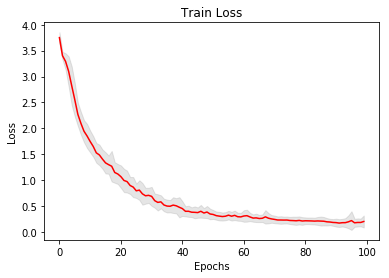

In [19]:
l = torch.tensor(loss)
loss_m = l.mean(0)
loss_std = l.std(0)
xdata=list(range(l.size(1)))

plt.figure('Final results')
plt.title('Train Loss')
plt.xlabel('Epochs') ; plt.ylabel('Loss')
plt.plot(xdata, loss_m.tolist(), 'r')
plt.fill_between(xdata, (loss_m - loss_std).tolist(), (loss_m + loss_std).tolist(),color='gray', alpha=0.2)
plt.show()

# Combined model. Train with 100 epochs!

In [14]:
def test_model_joint(train_i_org, train_c_org, train_t_org, test_i_org=None, test_c_org=None, test_t_org=None, runs=10, epochs=25):
    
    # shuffle train
    train_i_org, train_c_org, train_t_org = shuffle(train_i_org.view(train_i_org.size(0)//2, 2, train_i_org.size(2), -1), train_c_org.view(train_c_org.size(0)//2, -1), train_t_org)
    idx = list(range(train_i_org.size(0)))
    max_l = train_i_org.size(0)
    
    nb_error_test = []
    loss = []
    
    for k in range(runs):
        model = Net_All(16, 32, 64, 100)
        
        # if validation mode for hyperparameter tunning
        if test_i_org is None:
            test_idx = idx[max_l//10*k: max_l//10*(k+1)]
            train_idx =  [i for i in idx if i not in set(test_idx)]
            train_i, test_i = train_i_org[train_idx, :, :, :], train_i_org[test_idx, :, :, :]
            train_c, test_x = train_c_org[train_idx, :], train_c_org[test_idx, :]
            train_t, test_t = train_t_org[train_idx, :], train_t_org[test_idx, :]
        else:
            test_i, train_i = test_i_org, train_i_org
            test_c, train_c = test_c_org, train_c_org
            test_t, train_t = test_t_org, train_t_org

        # train model
        loss.append(train_model_all(model, train_i.view(-1, 1, train_i.size(2), train_i.size(3)), train_c.view(-1,10), train_t, lr=0.5, verbose=2, epochs=epochs))

        # get output from test
        out_class, out_target = model(test_i.view(-1, 1, test_i.size(2), test_i.size(3)))
        _, argmax_class = out_class.max(1)
        _, pred = out_target.max(1)
        _, argm_t = test_t.max(1)
        nb_test_errors = argm_t.size(0)  - (pred == argm_t).sum(0)
        nb_error_test.append(100.0 * nb_test_errors/argm_t.size(0))
        print('test error Net {:0.2f}% {:d}/{:d}'.format((100.0 * nb_test_errors) / argm_t.size(0),
                                                          nb_test_errors, argm_t.size(0)))
    
    p = sum([params.numel() for params in model.parameters()])
    print('Model with {} parameters'.format(p))
    errors = torch.tensor(nb_error_test).type(torch.FloatTensor)
    print('Mean error: {:0.2f} Std deviation in error: {:0.2f}'.format(errors.mean(), errors.std()))
    return nb_error_test, loss

In [15]:
errors, loss = test_model_joint(train_input, train_classes_one_hot, train_target_bin, epochs=100)

Training Composed model
test error Net 4.00% 4/100
Training Composed model
test error Net 12.00% 12/100
Training Composed model
test error Net 15.00% 15/100
Training Composed model
test error Net 15.00% 15/100
Training Composed model
test error Net 11.00% 11/100
Training Composed model
test error Net 11.00% 11/100
Training Composed model
test error Net 10.00% 10/100
Training Composed model
test error Net 6.00% 6/100
Training Composed model
test error Net 2.00% 2/100
Training Composed model
test error Net 17.00% 17/100
Model with 82856 parameters
Mean error: 10.30 Std deviation in error: 4.95


In [33]:
a, b = train_classes_one_hot.max(1)
b.view(-1,1).shape

torch.Size([2000, 1])

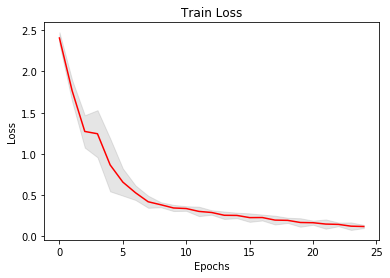

In [29]:
l = torch.tensor(loss)
loss_m = l.mean(0)
loss_std = l.std(0)
xdata=list(range(l.size(1)))

plt.figure('Final results')
plt.title('Train Loss')
plt.xlabel('Epochs') ; plt.ylabel('Loss')
plt.plot(xdata, loss_m.tolist(), 'r')
plt.fill_between(xdata, (loss_m - loss_std).tolist(), (loss_m + loss_std).tolist(),color='gray', alpha=0.2)
plt.show()

In [17]:
errors, loss = test_model_joint(train_input, train_classes_one_hot, train_target_bin, test_input, test_classes_one_hot, test_target_bin, epochs=100)

Training Composed model
test error Net 10.00% 101/1000
Training Composed model
test error Net 8.00% 85/1000
Training Composed model
test error Net 8.00% 84/1000
Training Composed model
test error Net 6.00% 62/1000
Training Composed model
test error Net 15.00% 156/1000
Training Composed model
test error Net 8.00% 82/1000
Training Composed model
test error Net 12.00% 120/1000
Training Composed model
test error Net 10.00% 100/1000
Training Composed model
test error Net 11.00% 110/1000
Training Composed model
test error Net 8.00% 80/1000
Model with 82856 parameters
Mean error: 9.60 Std deviation in error: 2.59


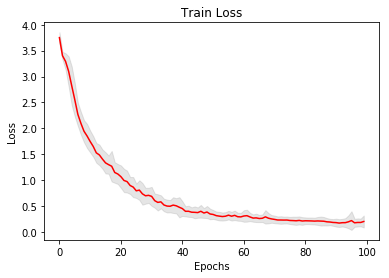

In [18]:
l = torch.tensor(loss)
loss_m = l.mean(0)
loss_std = l.std(0)
xdata=list(range(l.size(1)))

plt.figure('Final results')
plt.title('Train Loss')
plt.xlabel('Epochs') ; plt.ylabel('Loss')
plt.plot(xdata, loss_m.tolist(), 'r')
plt.fill_between(xdata, (loss_m - loss_std).tolist(), (loss_m + loss_std).tolist(),color='gray', alpha=0.2)
plt.show()